In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from astropy.coordinates import SkyCoord
from astropy.table import Table, setdiff
from astropy import units as u

from astroquery.vizier import Vizier

import matplotlib.pyplot as plt

import swasputils

In [3]:
CATALOGUES = {
    'J/BaltA/9/646/catalog': {
        'keys': ['GCVS', 'RAdeg', 'DEJ2000', 'Per'],
        'coords': lambda t: SkyCoord(t['RAdeg'], t['DEJ2000'], unit=(u.deg, u.deg)),
        'mag': lambda t: t['magMax'],
    },
    'J/ApJS/247/44/table2': {
        'keys': ['_2MASS', 'FileName'],
        'coords': lambda t: SkyCoord(t['RAJ2000'], t['DEJ2000'], unit=(u.hour, u.deg)),
        'mag': lambda t: t['Rmag'],
    },
}

In [4]:
Vizier.ROW_LIMIT = -1
full_catalogues = Vizier.get_catalogs(CATALOGUES)
full_catalogues

TableList with 2 tables:
	'0:J/BaltA/9/646/catalog' with 12 column(s) and 1103 row(s) 
	'1:J/ApJS/247/44/table2' with 15 column(s) and 4132 row(s) 

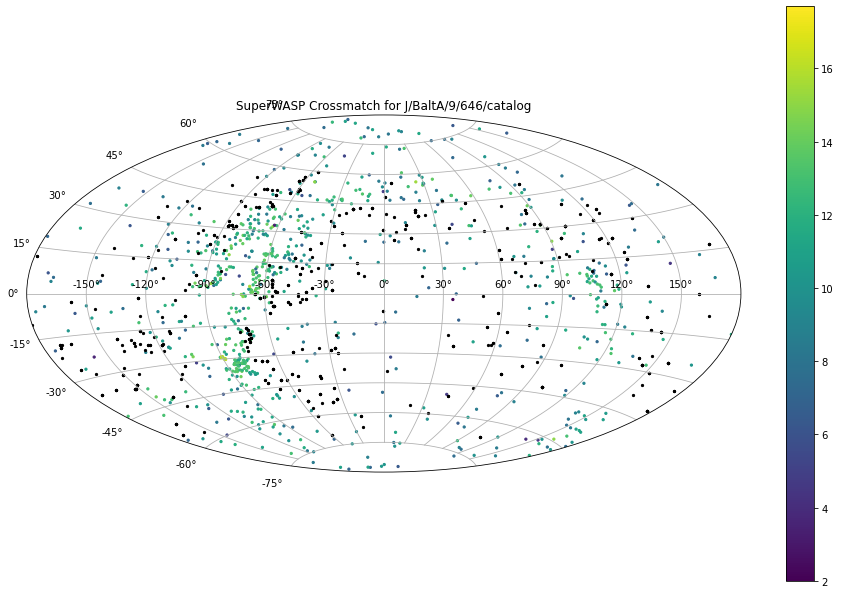

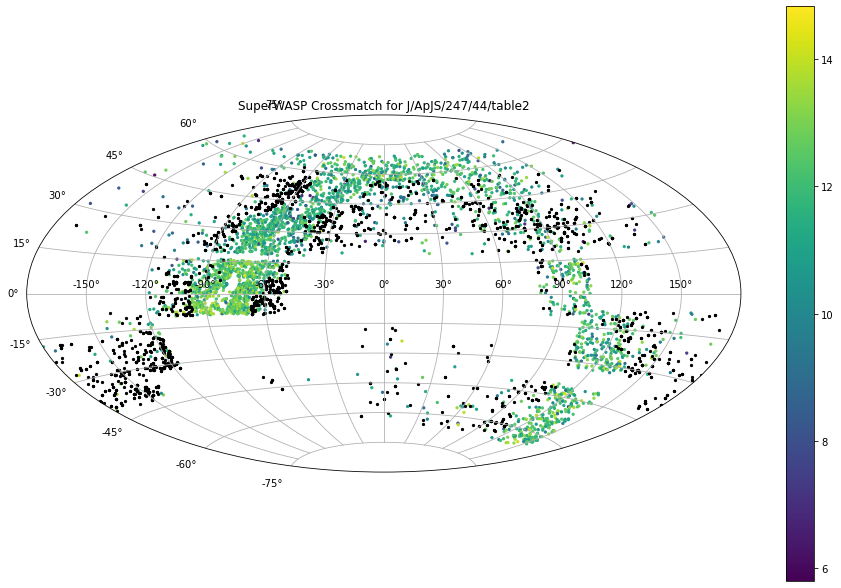

In [5]:
for catalogue, col_transforms in CATALOGUES.items():
    catalogue_escaped = catalogue.replace('/', '_')
    
    matched_sources = Table.read(os.path.join(swasputils.CACHE_LOCATION, f'catalogue_match_{catalogue_escaped}.ecsv'))
    matched_coords = col_transforms['coords'](matched_sources)                        
    matched_ra_rad = matched_coords.ra.wrap_at(180 * u.deg).radian
    matched_dec_rad = matched_coords.dec.radian
    
    unmatched_sources = setdiff(full_catalogues[catalogue], matched_sources, keys=col_transforms['keys'])
    unmatched_coords = col_transforms['coords'](unmatched_sources)
    unmatched_ra_rad = unmatched_coords.ra.wrap_at(180 * u.deg).radian
    unmatched_dec_rad = unmatched_coords.dec.radian
    
    plt.figure(figsize=(16,8.4))
    plt.subplot(111, projection="aitoff")
    plt.title(f'SuperWASP Crossmatch for {catalogue}')
    plt.grid(True)
    sc = plt.scatter(unmatched_ra_rad, unmatched_dec_rad, s=5, c=col_transforms['mag'](unmatched_sources))
    plt.colorbar(sc)
    plt.scatter(matched_ra_rad, matched_dec_rad, s=5, c='black')
    plt.subplots_adjust(top=0.95, bottom=0.0)
    plt.show()